# Starting a New Restaurant in San Francisco

## Business Problem

It's a rainy weekend in San Francisco and you're sitting at a table across with your three best friends, spit-balling dreams of owning
your own restaurant. You don't know much about what you have to do logistically to acquire or build a restaurant, but you and your friends 
seem to have millions of ideas for the types of drinks, food and atmosphere that would make your restaurant the best in the city.
You have a heated debate over the optimal neighborhood for setting up shop, but you can all agree that you would like it to be located
in a safer part of the city and in a spot where people already tend to hang out. Assuming money isn't an issue, and you can just charge
$9 for a beer to keep up with being located in the more expensive parts of town, how can you figure out the best place in the city
to start your dream Restaurant?

That's what this project aims to figure out.

## Target Audience

The target audience of this report would be anyone who wants to buy or build a restaurant in San Francisco, or anyone in San Francisco just looking for a nice area to have food and drink

# Data

In order to best make this decision, we're gonna need some data. Fortunately, the city of San Francisco has hundreds of public datasets that describe various aspects of the city, and Foursquare API allows free access to some of its location and venue data.

Altogether, we are looking at three sets of data for our analysis:

1. [San Francisco Crime Data](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783).
- This is going to help us by providing a list of every neighborhood in San Francisco, and allowing us to select one of the safest areas for our restaurant.

2. [San Francisco Registered Business Data](https://data.sfgov.org/Economy-and-Community/Registered-Business-Locations-San-Francisco/g8m3-pdis)
- This is going to help us roughly gauge the foot traffic in each neighborhood of San Francisco (at least on the weekdays) by providing the number of businesses located within each neighborhood.


3. Foursquare API
- Foursquare data is robust and provides location data for Apple and Uber. Foursquare API allows you to retrieve information about the most popular spots in each neighborhood in San Francisco. This will be another good indication of foot traffic for particular venue types. Calling the Foursquare API returns a JSON file, which can be turned into a dataframe for analysis in python.

# Methodology

In [4]:
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [5]:
CLIENT_ID = 'UL00CRZZHTTJ43RUWU2P13DINJ2N1MJFG10A10HTTI42AEMJ' # your Foursquare ID
CLIENT_SECRET = 'ZTN0UPN3ZVZVGMS3ABXO1ES0IQB2C21KJMVDRYXXF0RXNYRU' # your Foursquare Secret
ACCESS_TOKEN = 'QHE55KQWWZ3JLIJ2G24EGAN5J10NSA3MNJONNIJUZ5Q4OGVF' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: UL00CRZZHTTJ43RUWU2P13DINJ2N1MJFG10A10HTTI42AEMJ
CLIENT_SECRET:ZTN0UPN3ZVZVGMS3ABXO1ES0IQB2C21KJMVDRYXXF0RXNYRU


### Registered Business Data

In [6]:
business = pd.read_csv('https://data.sfgov.org/api/views/g8m3-pdis/rows.csv?accessType=DOWNLOAD')
print(business.shape)
business.head()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(276382, 32)


,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,Location Start Date,Location End Date,Mail Address,Mail City,Mail Zipcode,Mail State,NAICS Code,NAICS Code Description,Parking Tax,Transient Occupancy Tax,LIC Code,LIC Code Description,Supervisor District,Neighborhoods - Analysis Boundaries,Business Corridor,Business Location,UniqueID,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Neighborhoods
0,1280241-06-211,15092,Jug Shop Inc,Jug Shop Inc.,1648 Pacific Ave,San Francisco,CA,94109,10/01/1968,NaN,06/14/2021,NaN,1648 Pacific Ave,San Francisco,94109,CA,4400-4599,Retail Trade,False,False,NaN,NaN,3.0,Russian Hill,NaN,POINT (-122.42239 37.794952),1280241-06-211-0015092-4400-4599-06-14-2021,105.0,4.0,3.0,32.0,105.0
1,1281008-06-211,18971,Merrill Lynch Pierce Etal Inc,Merrill,1275 Fell St,San Francisco,CA,94117,01/01/2013,NaN,07/01/2020,NaN,401 N Tryon St 6th Fl,Charlotte,28255,NC,NaN,NaN,False,False,NaN,NaN,5.0,Hayes Valley,NaN,POINT (-122.438805 37.77388),1281008-06-211-0018971--07-01-2020,24.0,7.0,11.0,9.0,24.0
2,1281050-06-211,18971,Merrill Lynch Pierce Etal Inc,Merrill,500 Battery St,San Francisco,CA,94111,01/01/2013,NaN,07/01/2020,NaN,401 N Tryon St 6th Fl,Charlotte,28255,NC,NaN,NaN,False,False,NaN,NaN,3.0,Financial District/South Beach,NaN,POINT (-122.400475 37.795967),1281050-06-211-0018971--07-01-2020,77.0,6.0,3.0,8.0,77.0
3,0030032-46-001,30032,Walgreen Co,Walgreens #15567,845 Market St,San Francisco,CA,94103,10/01/1968,NaN,01/24/2014,01/25/2014,300 Wilmot Rd # Stop,Deerfield,60015,IL,4400-4599,Retail Trade,False,False,NaN,NaN,6.0,South of Market,NaN,POINT (-122.40681 37.784874),0030032-46-001-0030032-4400-4599-01-24-2014,32.0,5.0,10.0,34.0,32.0
4,0111807-01-001,111807,Burstein Jack B & Leatrice,1809 Oak Apts,1809 Oak St,San Francisco,CA,94117,04/01/1977,NaN,04/01/1977,NaN,437 Myrtle Ct,Benicia,94510,CA,7210-7219,Accommodations,False,False,NaN,NaN,5.0,Haight Ashbury,NaN,POINT (-122.44918 37.771614),0111807-01-001-0111807-7210-7219-04-01-1977,25.0,7.0,11.0,3.0,25.0


In [7]:
#just pull the columns we need
business2 = business[['Business Start Date','DBA Name', 'Neighborhoods - Analysis Boundaries']].copy()

#drop null values
business3 = business2.dropna()

#convert business start date to datetime
business3['Business Start Date'] = business3['Business Start Date'].astype('datetime64[ns]') 

#let's just look at areas that have seen the most businesses start in the last decade.
business4 = business3.loc[business3['Business Start Date'] > '2010-01-01']

#let's also rename 'Neighborhoods - Analysis Boundaries' to just be 'Neighborhoods'
business4.rename(columns={'Neighborhoods - Analysis Boundaries': 'Neighborhood'}, inplace = True)

#let's do the same thing for the business name
business4.rename(columns={'DBA Name': 'Business Name'}, inplace = True)

business4.head()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Business Start Date,Business Name,Neighborhood
1,2013-01-01,Merrill,Hayes Valley
2,2013-01-01,Merrill,Financial District/South Beach
10,2011-05-31,Marie Fisher Interior Design,Financial District/South Beach
18,2013-01-01,Merrill,Glen Park
19,2013-01-01,Merrill,Visitacion Valley


In [8]:
#Count the number of businesses in each neighborhood by grouping the data
business5 = business4.groupby('Neighborhood', as_index=False).count()
business5.reset_index()
#let's get rid of the business start date, we won't be needing it anymore
business5.drop(columns = 'Business Start Date',inplace = True)
#rename our "business name" column to "Businesses" to reflect the count per neighborhood
business5.rename(columns={'Business Name': 'Businesses'}, inplace = True)
#and sort the data
business6 = business5.sort_values(by= ['Businesses'], ascending = False).head(10)
business6.reset_index(drop=True)
business6

,Neighborhood,Businesses
5,Financial District/South Beach,20612
18,Mission,10912
33,South of Market,9399
34,Sunset/Parkside,6397
0,Bayview Hunters Point,6190
16,Marina,4559
35,Tenderloin,4278
25,Outer Richmond,4275
2,Castro/Upper Market,4196
3,Chinatown,4043


In [9]:
#for reference, here is every neighborhood in SF as well as the count of registered businesses
business7 = business5.sort_values(by= ['Businesses'], ascending = False)
business7.reset_index(drop=True)
print(business7.shape)
business7

(41, 2)


,Neighborhood,Businesses
5,Financial District/South Beach,20612
18,Mission,10912
33,South of Market,9399
34,Sunset/Parkside,6397
0,Bayview Hunters Point,6190
16,Marina,4559
35,Tenderloin,4278
25,Outer Richmond,4275
2,Castro/Upper Market,4196
3,Chinatown,4043


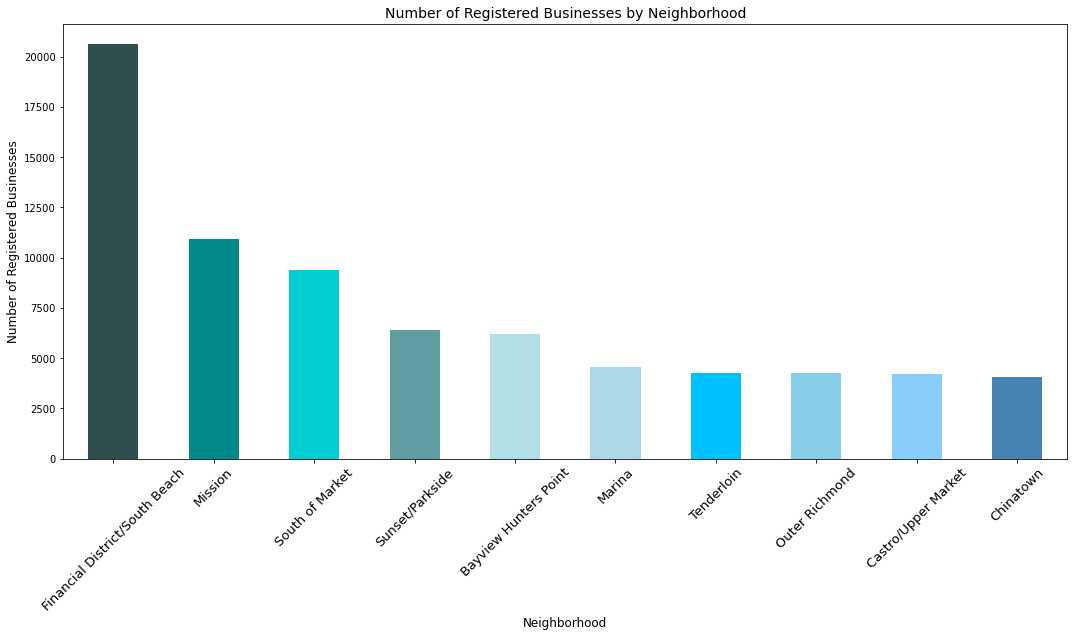

In [10]:
# now lets plot our data to get a good view
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt


business6.plot.bar(x = 'Neighborhood', y = 'Businesses', title = "Number of Registered Businesses by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['darkslategray','darkcyan','darkturquoise','cadetblue', 'powderblue','lightblue','deepskyblue','skyblue','lightskyblue','steelblue'])
plt.ylabel('Number of Registered Businesses', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Registered Businesses by Neighborhood', fontsize = 14)
plt.show()

It looks like the Financial District has the most businesses, but there are plenty of others that have lots of people working! Let's use the top 10 neighborhoods as our starting point.

Next, we want to make sure our restaurant is in a safe part of town. So let's use San Francisco's crime data from the last 5 years to narrow down our list.

### Crime Data

In [11]:
crime = pd.read_csv('https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD')
print(crime.shape)
crime.head()

(483066, 34)


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,Point,Neighborhoods,ESNCAG - Boundary File,Central Market/Tenderloin Boundary Polygon - Updated,Civic Center Harm Reduction Project Boundary,HSOC Zones as of 2018-06-05,Invest In Neighborhoods (IIN) Areas,Current Supervisor Districts,Current Police Districts
0,2019/03/05 09:00:00 PM,2019/03/05,21:00,2019,Tuesday,2019/03/07 12:54:00 PM,77808706372,778087,196048512,NaN,II,Coplogic Initial,True,6372,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, $50-$200",Open or Active,UNITED NATIONS PLZ \ LEAVENWORTH ST,30044000.0,Tenderloin,Tenderloin,6.0,37.779992,-122.413487,POINT (-122.41348740024354 37.77999173926721),21.0,NaN,1.0,1.0,1.0,NaN,10.0,5.0
1,2018/12/22 12:00:00 PM,2018/12/22,12:00,2018,Saturday,2018/12/26 02:29:00 PM,75246907023,752469,180971777,183601903.0,VI,Vehicle Initial,NaN,7023,Motor Vehicle Theft,Motor Vehicle Theft,"Vehicle, Stolen, Motorcycle",Open or Active,LINDEN ST \ BUCHANAN ST,25931000.0,Northern,Hayes Valley,5.0,37.775787,-122.427819,POINT (-122.42781910073226 37.77578657487239),22.0,NaN,NaN,NaN,NaN,NaN,11.0,4.0
2,2018/08/24 05:30:00 PM,2018/08/24,17:30,2018,Friday,2018/08/24 07:35:00 PM,70675306243,706753,180639339,182363732.0,II,Initial,NaN,6243,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, $200-$950",Open or Active,PERU AVE \ BURROWS ST,21610000.0,Ingleside,Excelsior,9.0,37.723944,-122.422830,POINT (-122.42283006837721 37.72394419349765),90.0,NaN,NaN,NaN,NaN,NaN,2.0,9.0
3,2018/10/20 03:10:00 PM,2018/10/20,15:10,2018,Saturday,2018/10/20 03:10:00 PM,72826462071,728264,180624631,182933454.0,IS,Initial Supplement,NaN,62071,Warrant,Other,Probation Search,Cite or Arrest Adult,BOARDMAN PL \ BRYANT ST,23914000.0,Southern,South of Market,6.0,37.775161,-122.403636,POINT (-122.40363551943442 37.7751608100771),32.0,NaN,NaN,NaN,NaN,NaN,10.0,1.0
4,2019/06/05 12:36:00 AM,2019/06/05,00:36,2019,Wednesday,2019/06/05 12:37:00 AM,80823030140,808230,190403077,191560061.0,II,Initial,NaN,30140,Other Offenses,Other,"Air Gun, Possession",Cite or Arrest Adult,LOMBARD ST \ NEWELL ST,30035000.0,Central,North Beach,3.0,37.802755,-122.413623,POINT (-122.4136227157606 37.80275505740129),106.0,NaN,NaN,NaN,NaN,NaN,3.0,6.0


In [12]:
#take just the columns we need
crime1 = crime[['Analysis Neighborhood','Incident Category', 'Incident Date']]

#drop all null values
crime2 = crime1.dropna()

#convert incident date to datetime
crime2['Incident Date'] = crime2['Incident Date'].astype('datetime64[ns]') 

#filter to just crimes in the last 5 years, as the neighborhoods in san francisco are rapidly changing and being gentrified, we want data that is relevant to today's crime.
crime3 = crime2.loc[crime2['Incident Date'] > '2015-01-01']

#There's lots of scary crimes out there, but let's make sure we aren't factoring in non-criminal police reports, because that data will pollute our insights.
crime4 = crime3.loc[crime3['Incident Category'] != 'Non-Criminal']

#change the name of 'Analysis Neighborhood' to 'Neighborhood'
crime4.rename(columns={'Analysis Neighborhood': 'Neighborhood'}, inplace = True)

crime4.head(20)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Incident Category,Incident Date
0,Tenderloin,Larceny Theft,2019-03-05
1,Hayes Valley,Motor Vehicle Theft,2018-12-22
2,Excelsior,Larceny Theft,2018-08-24
3,South of Market,Warrant,2018-10-20
4,North Beach,Other Offenses,2019-06-05
5,Financial District/South Beach,Larceny Theft,2019-02-12
6,Bayview Hunters Point,Other Miscellaneous,2018-12-07
7,Financial District/South Beach,Burglary,2018-10-04
8,Bayview Hunters Point,Offences Against The Family And Children,2019-05-17
9,Japantown,Robbery,2019-01-31


In [13]:
#count the number of crimes in each neighborhood
crime5 = crime4.groupby('Neighborhood', as_index=False).count()
#get rid of Incident Date
crime5.drop(columns = 'Incident Date',inplace = True)
#rename our column to reflect the counts of incidents
crime5.rename(columns={'Incident Category': 'Incidents'}, inplace = True)
#and sort our values
crime6 = crime5.sort_values(by= ['Incidents'], ascending = False)
crime7 = crime6.head(10)
crime7

,Neighborhood,Incidents
18,Mission,47074
35,Tenderloin,42924
5,Financial District/South Beach,36527
33,South of Market,34687
0,Bayview Hunters Point,27573
40,Western Addition,13927
22,North Beach,13633
2,Castro/Upper Market,13220
20,Nob Hill,12486
34,Sunset/Parkside,12438


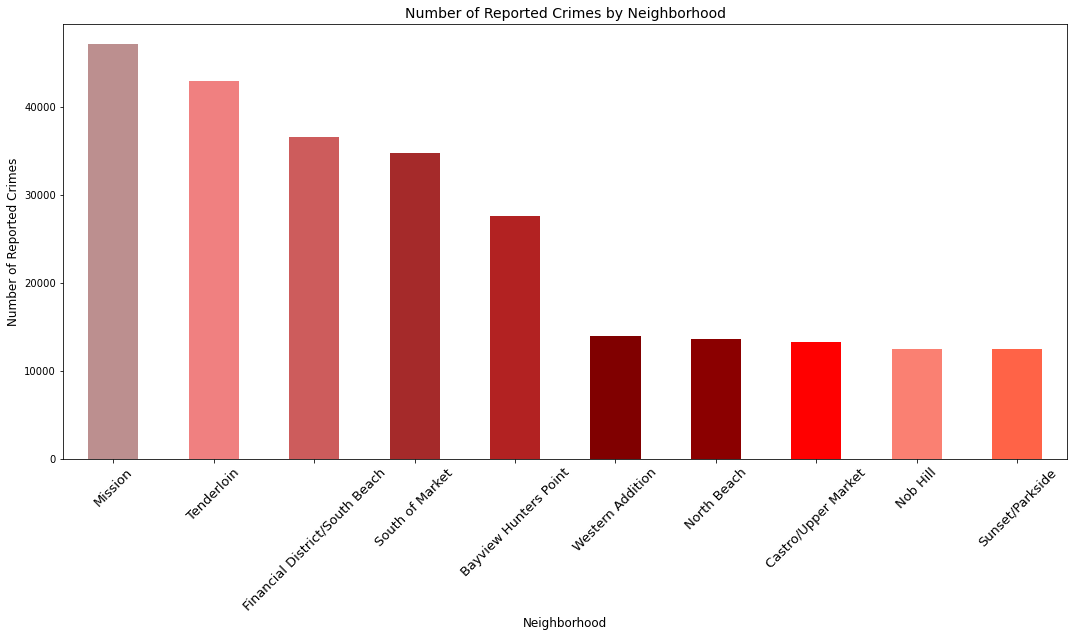

In [14]:
# Lets have a look at our data graphically
crime7.plot.bar(x = 'Neighborhood', y = 'Incidents', title = "Crime Incidents by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'salmon', 'tomato'])
plt.ylabel('Number of Reported Crimes', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Reported Crimes by Neighborhood', fontsize = 14)
plt.show()

It looks like there are 5 spots with heavy crime rates in San Francisco, and the rest seem on par with eachother.

Let's take our 10 favorite neighborhoods from before and sort out these 5 Neighborhoods with the highest crime rate


In [15]:
#get a dataframe with the 5 highest incident neighborhoods
crime8 = crime7.head(5)
crime8

,Neighborhood,Incidents
18,Mission,47074
35,Tenderloin,42924
5,Financial District/South Beach,36527
33,South of Market,34687
0,Bayview Hunters Point,27573


In [16]:
'''start by merging the datasets and making a new dataset that incldues the neighborhoods 
which were among the top 10 for businesses AND are among the top 5 for crime '''
Overlap = business6.merge(crime8, on=['Neighborhood'])
'''then take this joined dataframe and remove all common values from your list of top 10 
neighborhoods for businesses'''
SF_Neighborhoods = business6[(~business6.Neighborhood.isin(Overlap.Neighborhood))]
'''and what you have is the top neighborhoods for businesses that are NOT the top 
neighborhoods for crime'''
SF_Neighborhoods.head()

,Neighborhood,Businesses
34,Sunset/Parkside,6397
16,Marina,4559
25,Outer Richmond,4275
2,Castro/Upper Market,4196
3,Chinatown,4043


Now lets get the coordinates for each of our neighbourhoods 

In [17]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_explorer")
SF_Neighborhoods['Coordinates'] = SF_Neighborhoods['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
SF_Neighborhoods

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Neighborhood,Businesses,Coordinates
34,Sunset/Parkside,6397,"(42.756152099999994, -81.19147399988015)"
16,Marina,4559,"(43.5139149, 16.1092196)"
25,Outer Richmond,4275,"(44.108805, -69.798725)"
2,Castro/Upper Market,4196,"(-37.3830729, 175.67941)"
3,Chinatown,4043,"(40.7164913, -73.9962504)"


looks like geopy had them all over the place. Marina and Outer Richmond seem to be right, but let's plug in values from Google Maps for the rest and clean up the coordinates a little.

In [19]:
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Sunset/Parkside' , 'Coordinates'] = "(37.751616, -122.490810)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Outer Richmond' , 'Coordinates'] = "(37.780001, -122.490229)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Castro/Upper Market' , 'Coordinates'] = "(37.762932, -122.435395)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Chinatown' , 'Coordinates'] = "(37.773972, -122.431297)"
SF_Neighborhoods.loc[SF_Neighborhoods.Neighborhood == 'Marina' , 'Coordinates'] = "(37.801406, -122.439718)"
SF_Neighborhoods

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Neighborhood,Businesses,Coordinates
34,Sunset/Parkside,6397,"(37.751616, -122.490810)"
16,Marina,4559,"(37.801406, -122.439718)"
25,Outer Richmond,4275,"(37.780001, -122.490229)"
2,Castro/Upper Market,4196,"(37.762932, -122.435395)"
3,Chinatown,4043,"(37.773972, -122.431297)"


### Merging datasets

Now, we can add the latitude and longitude in separate columns and merge our datasets

In [20]:
SF = SF_Neighborhoods.merge(crime6, on=['Neighborhood'])
SF.rename(columns={'Incidents':'Crimes'}, inplace = True)
SF = SF[['Neighborhood', 'Businesses', 'Crimes','Coordinates']]
SF['Coordinates'].to_string()
SF[['Latitude','Longitude']] = SF['Coordinates'].str.strip('(').str.strip(')').str.split(', ', expand=True)

SF

,Neighborhood,Businesses,Crimes,Coordinates,Latitude,Longitude
0,Sunset/Parkside,6397,12438,"(37.751616, -122.490810)",37.751616,-122.490810
1,Marina,4559,11945,"(37.801406, -122.439718)",37.801406,-122.439718
2,Outer Richmond,4275,9891,"(37.780001, -122.490229)",37.780001,-122.490229
3,Castro/Upper Market,4196,13220,"(37.762932, -122.435395)",37.762932,-122.435395
4,Chinatown,4043,7831,"(37.773972, -122.431297)",37.773972,-122.431297


### Foursquare Data Analysis 

Lets write a function to search the most popular venues within a 0.5 mile radius of our neighbourhoods

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
SF_venues = getNearbyVenues(names=SF['Neighborhood'],
                                   latitudes=SF['Latitude'],
                                   longitudes=SF['Longitude']
                                  )

Sunset/Parkside
Marina
Outer Richmond
Castro/Upper Market
Chinatown


In [23]:
#Le'ts see the shape of our dataframe
print(SF_venues.shape)
SF_venues.head()

(150, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sunset/Parkside,37.751616,-122.490810,TJ Brewed Tea and Real Fruit (TJ Cups),37.753561,-122.490028,Bubble Tea Shop
1,Sunset/Parkside,37.751616,-122.490810,Polly Ann Ice Cream,37.753454,-122.497765,Ice Cream Shop
2,Sunset/Parkside,37.751616,-122.490810,S&T Hong Kong Seafood,37.753702,-122.491278,Dim Sum Restaurant
3,Sunset/Parkside,37.751616,-122.490810,Sunset Recreation Center,37.757310,-122.487072,Playground
4,Sunset/Parkside,37.751616,-122.490810,Donut Time,37.753651,-122.489439,Donut Shop


In [24]:
#take a look at how many venues were pulled for each neighborhood
SF_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Castro/Upper Market,30,30,30,30,30,30
Chinatown,30,30,30,30,30,30
Marina,30,30,30,30,30,30
Outer Richmond,30,30,30,30,30,30
Sunset/Parkside,30,30,30,30,30,30


In [25]:
#the number of unique types of venues pulled
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 90 uniques categories.


what are the most common venue categories in our 5 selected neighborhoods?

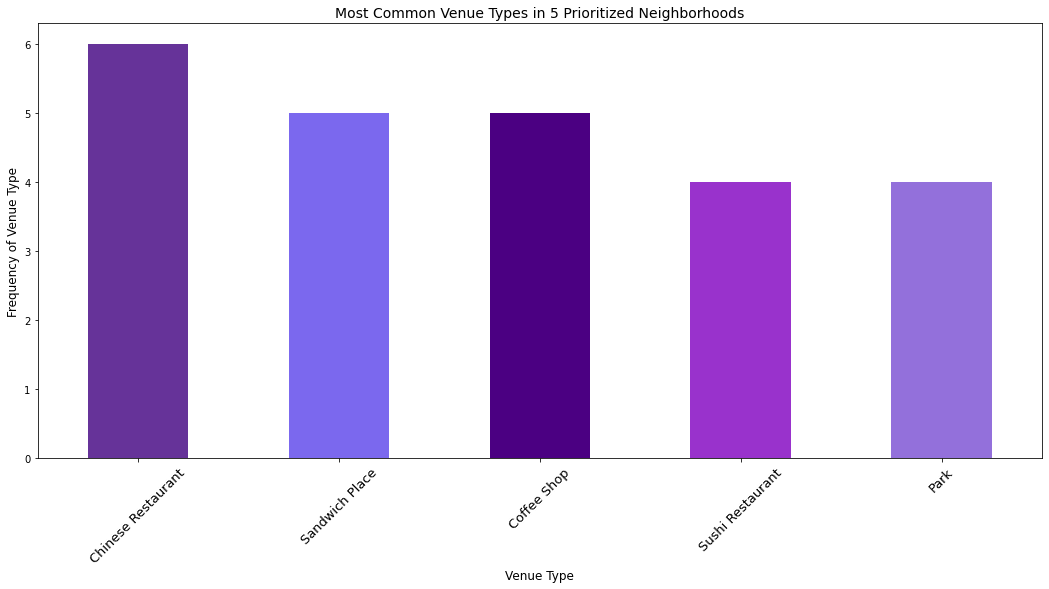

In [26]:
SF_top_venues = SF_venues.groupby('Venue Category', as_index = False).count().sort_values('Neighborhood', ascending = False).head(5)
SF_top_venues = SF_top_venues[['Venue Category','Neighborhood']]
SF_top_venues.rename(columns={'Neighborhood': 'Frequency'}, inplace = True)
SF_top_venues.plot.bar(x='Venue Category', y='Frequency', legend = None, title = "Most common venue types in 5 prioritized neighborhoods", rot= 45, figsize = (18, 8), color=['rebeccapurple','mediumslateblue','indigo','darkorchid','mediumpurple'])
plt.ylabel('Frequency of Venue Type', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Venue Type', fontsize=12)
plt.title('Most Common Venue Types in 5 Prioritized Neighborhoods', fontsize = 14)
plt.show()


It looks like Restaurants are the most common venue type, followed by coffee shops, and finally parks.

Let's do some one hot encoding to further analyze our results.

In [27]:
# one hot encoding
SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SF_onehot['Neighborhood'] = SF_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [SF_onehot.columns[-1]] + list(SF_onehot.columns[:-1])
SF_onehot = SF_onehot[fixed_columns]

SF_onehot.head()

,Neighborhood,Alternative Healer,American Restaurant,Antique Shop,Arts & Crafts Store,BBQ Joint,Bakery,Bank,Bar,Bike Shop,Bookstore,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Café,Candy Store,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Cupcake Shop,Cycle Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Electronics Store,Elementary School,Farmers Market,Field,Flea Market,Food Truck,French Restaurant,Gastropub,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lake,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle School,Moroccan Restaurant,New American Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Playground,Public Art,Ramen Restaurant,Record Shop,Restaurant,Roller Rink,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Spa,Spiritual Center,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Thai Restaurant,Tiki Bar,Trail,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Sunset/Parkside,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
#examine shape of new dataframe
SF_onehot.shape

(150, 91)

In [29]:
#now group the data
SF_grouped = SF_onehot.groupby('Neighborhood').mean().reset_index()
print(SF_grouped.shape)
SF_grouped

(5, 91)


,Neighborhood,Alternative Healer,American Restaurant,Antique Shop,Arts & Crafts Store,BBQ Joint,Bakery,Bank,Bar,Bike Shop,Bookstore,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Café,Candy Store,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Cupcake Shop,Cycle Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Donut Shop,Electronics Store,Elementary School,Farmers Market,Field,Flea Market,Food Truck,French Restaurant,Gastropub,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lake,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle School,Moroccan Restaurant,New American Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Playground,Public Art,Ramen Restaurant,Record Shop,Restaurant,Roller Rink,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Southern / Soul Food Restaurant,Spa,Spiritual Center,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Thai Restaurant,Tiki Bar,Trail,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Castro/Upper Market,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.066667,0.033333,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.066667,0.033333,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333
1,Chinatown,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.033333,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.033333,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.033333
2,Marina,0.033333,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.033333,0.033333,0.000000,0.066667,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000
3,Outer Richmond,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.100000,0.000000,0.033333,0.000000,0.033333,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0

We can now see the frequency of the top 5 types of venues for each neighborhood.

In [30]:
#print each neighborhood with the top 5 most common venues
num_top_venues = 5

for hood in SF_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = SF_grouped[SF_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Castro/Upper Market----
                     venue  freq
0              Coffee Shop  0.07
1  New American Restaurant  0.07
2              Yoga Studio  0.03
3       Seafood Restaurant  0.03
4             Cycle Studio  0.03


----Chinatown----
              venue  freq
0              Park  0.07
1  Sushi Restaurant  0.07
2          Dive Bar  0.07
3       Pizza Place  0.03
4    Sandwich Place  0.03


----Marina----
                venue  freq
0       Deli / Bodega  0.07
1   Electronics Store  0.07
2  Alternative Healer  0.03
3      Clothing Store  0.03
4      Cosmetics Shop  0.03


----Outer Richmond----
                venue  freq
0                Café  0.10
1  Seafood Restaurant  0.07
2  Mexican Restaurant  0.03
3          Playground  0.03
4         Flea Market  0.03


----Sunset/Parkside----
                 venue  freq
0   Chinese Restaurant  0.13
1   Dim Sum Restaurant  0.07
2  Japanese Restaurant  0.07
3           Playground  0.07
4       Farmers Market  0.03




Now we can place our data into a dataframe of the most popular venues for each neighborhood.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SF_grouped['Neighborhood']

for ind in np.arange(SF_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Castro/Upper Market,New American Restaurant,Coffee Shop,Yoga Studio,Historic Site,Park,Mediterranean Restaurant,Liquor Store,Indie Movie Theater,Indian Restaurant,Ice Cream Shop,History Museum,Gym,Public Art,Deli / Bodega,Cycle Studio,Cosmetics Shop,Candy Store,Burger Joint,Bookstore,Bakery,Arts & Crafts Store,Pet Store,Gym / Fitness Center,Seafood Restaurant,Wine Bar,Sandwich Place,Salon / Barbershop,Sushi Restaurant,Diner,Dim Sum Restaurant
1,Chinatown,Park,Dive Bar,Sushi Restaurant,Gift Shop,Dog Run,Wings Joint,German Restaurant,Historic Site,Ice Cream Shop,Roller Rink,Italian Restaurant,Korean Restaurant,Mediterranean Restaurant,Coffee Shop,Café,Pizza Place,Ramen Restaurant,Record Shop,Yoga Studio,BBQ Joint,Bar,Spiritual Center,Sandwich Place,Vietnamese Restaurant,Bakery,Spa,Bike Shop,Burger Joint,Dim Sum Restaurant,Diner
2,Marina,Deli / Bodega,Electronics Store,Pizza Place,Japanese Restaurant,Italian Restaurant,Hotpot Restaurant,Greek Restaurant,Gastropub,French Restaurant,Diner,Gym / Fitness Center,Cupcake Shop,Cosmetics Shop,Clothing Store,Chinese Restaurant,Burger Joint,Bookstore,Arts & Crafts Store,American Restaurant,Mexican Restaurant,Alternative Healer,Thai Restaurant,Supermarket,Wine Bar,Salad Place,Taco Place,Seafood Restaurant,Sandwich Place,Taiwanese Restaurant,Coffee Shop
3,Outer Richmond,Café,Seafood Restaurant,Park,New American Restaurant,Burmese Restaurant,Playground,Pizza Place,Burrito Place,Flea Market,Moroccan Restaurant,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Cosmetics Shop,Korean Restaurant,Japanese Restaurant,Deli / Bodega,Restaurant,Sushi Restaurant,Grocery Store,Antique Shop,Trail,Tiki Bar,Taiwanese Restaurant,Italian Restaurant,Southern / Soul Food Restaurant,Sandwich Place,Dog Run,Cycle Studio,Donut Shop
4,Sunset/Parkside,Chinese Restaurant,Dim Sum Restaurant,Playground,Japanese Restaurant,Pharmacy,Bubble Tea Shop,Dessert Shop,Lake,Coffee Shop,Pizza Place,Bus Station,Donut Shop,Ice Cream Shop,Sandwich Place,Bank,Bar,Vietnamese Restaurant,Food Truck,Field,Hardware Store,Middle School,Farmers Market,Elementary School,Brewery,Dive Bar,Deli / Bodega,Dog Run,Diner,Flea Market,French Restaurant


## Clustering

Let's use K means clustering to cluster our neighborhoods for more insights!

In [33]:
# set number of clusters
kclusters = 3

SF_grouped_clustering = SF_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 2, 2, 0], dtype=int32)

Now create a dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

SF_merged = SF

In [35]:
# merge SF_grouped with SF_data to add latitude/longitude for each neighborhood
SF_merged = SF_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [37]:
#also including the number of bars and restaurants that each neighborhood has in its top 10 most popular spots.
SF_merged["Bars and Restaurants"] = ""
SF_merged.loc[SF_merged.Neighborhood == 'Sunset/Parkside', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'Outer Richmond', 'Bars and Restaurants'] = .6
SF_merged.loc[SF_merged.Neighborhood == 'Marina', 'Bars and Restaurants'] = .67
SF_merged.loc[SF_merged.Neighborhood == 'Castro/Upper Market', 'Bars and Restaurants'] = .37
SF_merged.loc[SF_merged.Neighborhood == 'Chinatown', 'Bars and Restaurants'] = .5
SF_merged['Bars and Restaurants'].astype(int)

0    0
1    0
2    0
3    0
4    0
Name: Bars and Restaurants, dtype: int64

In [38]:
SF_merged['Latitude'] = SF_merged['Latitude'].astype(float)
SF_merged['Longitude'] = SF_merged['Longitude'].astype(float)
SF_merged['Cluster Labels'] = SF_merged['Cluster Labels'].astype(int)

SF_merged

,Neighborhood,Businesses,Crimes,Coordinates,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,Bars and Restaurants
0,Sunset/Parkside,6397,12438,"(37.751616, -122.490810)",37.751616,-122.490810,0,Chinese Restaurant,Dim Sum Restaurant,Playground,Japanese Restaurant,Pharmacy,Bubble Tea Shop,Dessert Shop,Lake,Coffee Shop,Pizza Place,Bus Station,Donut Shop,Ice Cream Shop,Sandwich Place,Bank,Bar,Vietnamese Restaurant,Food Truck,Field,Hardware Store,Middle School,Farmers Market,Elementary School,Brewery,Dive Bar,Deli / Bodega,Dog Run,Diner,Flea Market,French Restaurant,0.37
1,Marina,4559,11945,"(37.801406, -122.439718)",37.801406,-122.439718,2,Deli / Bodega,Electronics Store,Pizza Place,Japanese Restaurant,Italian Restaurant,Hotpot Restaurant,Greek Restaurant,Gastropub,French Restaurant,Diner,Gym / Fitness Center,Cupcake Shop,Cosmetics Shop,Clothing Store,Chinese Restaurant,Burger Joint,Bookstore,Arts & Crafts Store,American Restaurant,Mexican Restaurant,Alternative Healer,Thai Restaurant,Supermarket,Wine Bar,Salad Place,Taco Place,Seafood Restaurant,Sandwich Place,Taiwanese Restaurant,Coffee Shop,0.67
2,Outer Richmond,4275,9891,"(37.780001, -122.490229)",37.780001,-122.490229,2,Café,Seafood Restaurant,Park,New American Restaurant,Burmese Restaurant,Playground,Pizza Place,Burrito Place,Flea Market,Moroccan Restaurant,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Cosmetics Shop,Korean Restaurant,Japanese Restaurant,Deli / Bodega,Restaurant,Sushi Restaurant,Grocery Store,Antique Shop,Trail,Tiki Bar,Taiwanese Restaurant,Italian Restaurant,Southern / Soul Food Restaurant,Sandwich Place,Dog Run,Cycle Studio,Donut Shop,0.6
3,Castro/Upper Market,4196,13220,"(37.762932, -122.435395)",37.762932,-122.435395,1,New American Restaurant,Coffee Shop,Yoga Studio,Historic Site,Park,Mediterranean Restaurant,Liquor Store,Indie Movie Theater,Indian Restaurant,Ice Cream Shop,History Museum,Gym,Public Art,Deli / Bodega,Cycle Studio,Cosmetics Shop,Candy Store,Burger Joint,Bookstore,Bakery,Arts & Crafts Store,Pet Store,Gym / Fitness Center,Seafood Restaurant,Wine Bar,Sandwich Place,Salon / Barbershop,Sushi Restaurant,Diner,Dim Sum Restaurant,0.37
4,Chinatown,4043,7831,"(37.773972, -122.431297)",37.773972,-122.431297,1,Park,Dive Bar,Sushi Restaurant,Gift Shop,Dog Run,Wings Joint,German Restaurant,Historic Site,Ice Cream Shop,Roller Rink,Italian Restaurant,Korean Restaurant,Mediterranean Restaurant,Coffee Shop,Café,Pizza Place,Ramen Restaurant,Record Shop,Yoga Studio,BBQ Joint,Bar,Spiritual Center,Sandwich Place,Vietnamese Restaurant,Bakery,Spa,Bike Shop,Burger Joint,Dim Sum Restaurant,Diner,0.5


Let's visualize the percentage of pupular venues in each neighborhood that are bars or restaurants. this will help us see which neighborhoods are more popular BECAUSE of their bar and restuaraunt scene, and which are popular for other reasons.

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


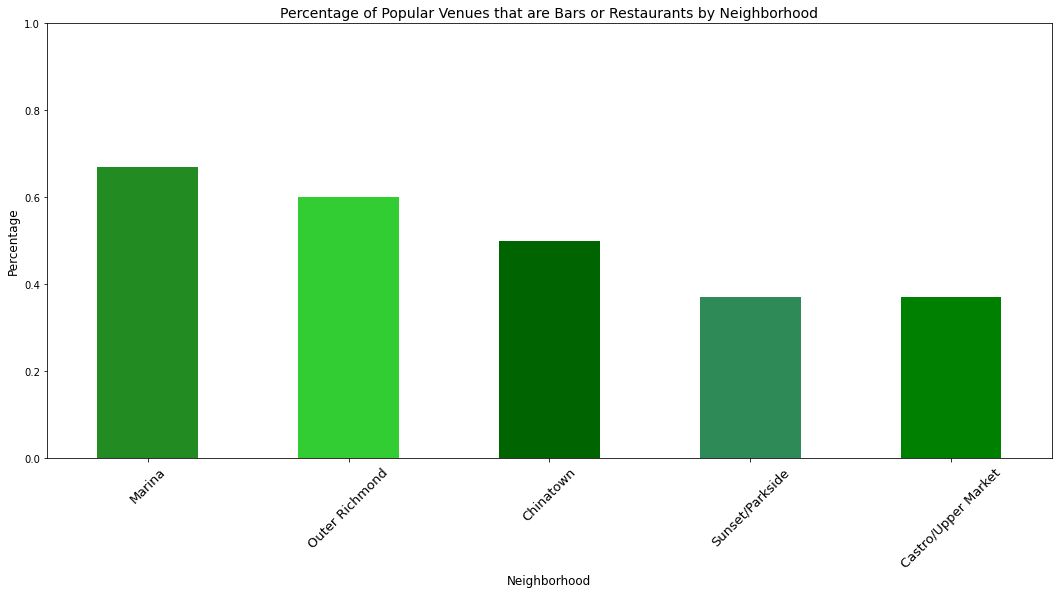

In [39]:
SF_rb = SF_merged[['Neighborhood','Bars and Restaurants']]
SF_rb.rename(columns={'Bars and Restaurants': 'Frequency'}, inplace = True)
SF_rb.sort_values('Frequency', inplace = True, ascending = False)
SF_rb.plot.bar(x='Neighborhood',y ='Frequency', rot = 45, figsize = (18, 8), legend = None, color = ['forestgreen','limegreen','darkgreen','seagreen','green','mediumseagreen'])
plt.ylabel('Percentage', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylim(0,1)
plt.title('Percentage of Popular Venues that are Bars or Restaurants by Neighborhood', fontsize = 14)
plt.show()

### Map Clustered Neighborhoods

Next, let's pull the coordinates for San Francisco and build a map.

In [40]:
address = 'San Francisco, California'

geolocator = Nominatim(user_agent="SF_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262, -122.419906.


Finally, let's map our clustered neighborhoods to see which ones are more similar.

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(.7, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
markers_colors = []
for lat, lon, poi, cluster, bars in zip(SF_merged['Latitude'], SF_merged['Longitude'], SF_merged['Neighborhood'], SF_merged['Cluster Labels'], SF_merged['Bars and Restaurants']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=35*bars,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

# Results and Discussion

We have pulled data on crime rates and business registrations for every neighborhood in San Francisco and used this information to narrow down our neighborhood options to 5 neighborhoods. Our analysis has informed us that:

Chinese Restaurants,Sandwich shops, Coffee shops, Sushi Restaurant, and Parks are the most common venues in our 5 preferred neighborhoods.
Clustering neighborhoods based on their most popular venues grouped Chinatown with Castro into a cluster, Outer Richmond and Marina into another cluster, and Sunset as its own independent cluster.
Marina and Outer Richmond have majority bars and restaurants as popular venues, whereas most of the popular venues in Sunset and Castro are not bars or restaurants, but locations like parks and yoga studios.
From Zumper’s report in Figure 2, we know Marina, Castro, are more expensive places to live, with the median rent for a one-bedroom of at least $3,500.
Sunset, Outer Richmond, and chinaTown are more affordable and have a median rent for a one-bedroom of less than $3,000.
Based on this analysis, Outer Richmond seems to offer a good balance between foot traffic, popularity for restaurants and bars, and rent prices. Marina seems to be a hot spot for restaurants and bars, but also comes with the high cost of rent. Castro come with the same expense as Marina, but neither is as hot of a destination for restaurants and dining. Sunset also has cheaper rent, but the popular spots tend to be more recreational in nature (e.g. lakes and playgrounds).

Ultimately, the optimal restaurant spot depends on what type of restaurant you would like to open. An upscale and trendy restaurant might fare better against competition in an expensive and bustling area like Marina, whereas a dive bar may be the go-to spot in an area like West of Twin Peaks, which likely receives most of its foot traffic exclusively from its residents.

A major drawback of this analysis is that the clustering was completely based on Foursquare’ s data for popular venues. There are plenty other ways to assess popularity of neighborhoods and the spots inside them, venue popularity is just one of them. It may also be helpful to look exclusively at restaurants in an area, how many there are, and how popular they are on weekdays and weekends